In [13]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)

In [14]:
# For this model, the data preprocessing part is already completed with the exception of scaling.
# so we just need to scale here.

In [15]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [16]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t3_data/{key}.pkl')
    return raw[key]

In [17]:
configurations = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_identifier' : "sample_e_0",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t3_models",
    'device' : 'cpu',
    'random_seed' : 0,
    'lr' : 1e-2,
    'momentum' : 0.95, #SGD
    'weight_decay' : 1e-6, #Adam
    'max_epochs' : 50000,
    'do_validate' : True,
    'model_definition' : {
        'layer0' : 120, 'relu1' : True,# 'drop1' : 0.5,
        'layer1' : 120, 'relu1' : True, 'drop1' : 0.5,
        'layer2' : 120, 'relu2' : True, 'drop2' : 0.5,
        'layer3' : 120, 'relu3' : True, 'drop3' : 0.5,
        'layer4' : 120, 'relu4' : True, 'drop4' : 0.5,
        'layer5' : 120, 'relu5' : True, 'drop5' : 0.5,
        'layer6' : 120, 'relu6' : True, 'drop6' : 0.5,
#         'layer7' : 100, 'relu7' : True,# 'drop7' : 0.5,
#         'layer8' : 100, 'relu8' : True,# 'drop8' : 0.5,
#         'layer9' : 100, 'relu9' : True,# 'drop9' : 0.5,
    },
    'train_params' : {
        'batch_size': 5000,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 1,
        'pin_memory': True,
    },
}

In [18]:
%%time

train_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=False))
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

train_df = train_df.dropna()
test_df = test_df.dropna()
train_df = train_df.sample(100000, random_state=42)
test_df = test_df.sample(10000, random_state=42)

ref_train, X_train, y_train = get_ref_X_y(train_df)
ref_test, X_test, y_test = get_ref_X_y(test_df)

Loading data to cache for: sample_train
Loading data to cache for: sample_test
CPU times: user 12.8 s, sys: 13.6 s, total: 26.4 s
Wall time: 21.8 s


In [19]:
y_cols = ['y_SAT_RX_ERROR', 'y_SAT_RY_ERROR', 'y_SAT_RZ_ERROR', 'y_SAT_VX_ERROR', 'y_SAT_VY_ERROR', 'y_SAT_VZ_ERROR']
y_cols = ['y_SAT_RX_ERROR']

y_train = y_train[y_cols]
y_test = y_test[y_cols]

y_train = np.sign(y_train) * np.log(1+np.abs(y_train))
y_test = np.sign(y_test) * np.log(1+np.abs(y_test))

In [20]:
model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model
NNModelEx(
  (net): Sequential(
    (0): Linear(in_features=37, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=120, bias=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=120, out_features=120, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=120, out_features=120, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=120, out_features=120, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=120, out_features=120, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=120, out_features=120, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.5, inplace=False)
    (19): Linear(in_features=120, out_features=1, bias=True)
  )
)


  0%|          | 0/48296 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

Loading existing model


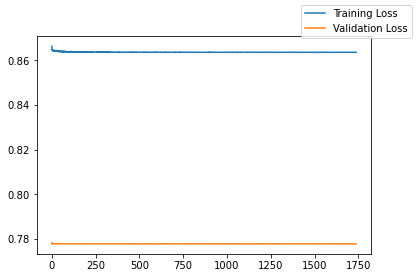

In [21]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [22]:
trained_model = model

In [23]:
y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_test_pred = train.predict(trained_model, X_test, y_test, device="cpu") # get predictions for each train
y_test_pred_df = pd.DataFrame(y_test_pred, columns=y_test.columns)  # put results into a dataframe

In [24]:
print(f'    Train set MAE (L1) loss: {mean_absolute_error(y_train, y_train_pred_df)}')
print(f'    Train set MSE (L2) loss: {mean_squared_error(y_train, y_train_pred_df)}')

# random.seed(0)
# sample = random.sample(list(y_train_pred_df.index), 10)

print("Train - Ground Truth (normalized):")
display(y_train)
# print("Train - Ground Truth (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train.iloc[:,3:].loc[sample].copy(), reverse=True))  # see ground truths
print("Train - Prediction (normalized):")
display(y_train_pred_df)
# print("Train - Prediction (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

    Train set MAE (L1) loss: 0.5013594356319754
    Train set MSE (L2) loss: 0.8635318581451457
Train - Ground Truth (normalized):


,y_SAT_RX_ERROR
6409032,0.311075
11353103,3.105288
7887336,-0.055494
8054584,-1.451223
2137530,0.035870
...,...
12974498,-0.073937
1616963,0.221085
7375134,1.164207
9137222,-0.449465


Train - Prediction (normalized):


,y_SAT_RX_ERROR
0,0.002204
1,0.002144
2,0.002184
3,0.002252
4,0.002245
...,...
99995,0.002122
99996,0.002135
99997,0.002145
99998,0.002086


In [ ]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_test, y_test_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_test, y_test_pred_df)}')

random.seed(0)
# sample = random.sample(list(y_train_pred_df.index), 10)
# sample = [0,1]

print("Train - Ground Truth (normalized):")
display(y_train.loc)
# print("Train - Ground Truth (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train.iloc[:,3:].loc[sample].copy(), reverse=True))  # see ground truths
print("Train - Prediction (normalized):")
display(y_train_pred_df.loc)
# print("Train - Prediction (non-normalized):")
# display(normalize_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

In [ ]:
# errors = y_train.loc[sample].iloc[:,3:] - y_train_pred_df.loc[sample]

# display(errors)

# display(errors.std())

# display(y_train.loc[sample].iloc[:,3:])
# display(y_train_pred_df.loc[sample])

In [ ]:
# def row_to_compare(X, y, y_pred, row):
#     epoch = X.iloc[row].EPOCH_y
#     X0 = clean_data.normalize_all_columns(X_train.iloc[row].copy(), reverse=True)
#     y0 = clean_data.normalize_all_columns(y_train.iloc[row].copy(), reverse=True)
#     y1 = clean_data.normalize_all_columns(y_train_pred_df.iloc[row].copy(), reverse=True)

#     # Ground truth
#     y0_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y0.ECCENTRICITY,
#                                           aop=y0.ARG_OF_PERICENTER,
#                                           inc=y0.INCLINATION,
#                                           mea=y0.MEAN_ANOMALY,
#                                           mem=y0.MEAN_MOTION,
#                                           raa=y0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Prediction
#     y1_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y1.ECCENTRICITY,
#                                           aop=y1.ARG_OF_PERICENTER,
#                                           inc=y1.INCLINATION,
#                                           mea=y1.MEAN_ANOMALY,
#                                           mem=y1.MEAN_MOTION,
#                                           raa=y1.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Propigation
#     y2_xyz = clean_data.get_satellite_xyz(bst=X0.BSTAR,
#                                           ecc=X0.ECCENTRICITY,
#                                           aop=X0.ARG_OF_PERICENTER,
#                                           inc=X0.INCLINATION,
#                                           mea=X0.MEAN_ANOMALY,
#                                           mem=X0.MEAN_MOTION,
#                                           raa=X0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     print(f'Ground Truth: {y0_xyz}')
#     print(f'Predicted: {y1_xyz}')
#     print(f'Propigation: {y2_xyz}')
    
#     print (f'Prediction Error: {sum((y1_xyz-y0_xyz)**2)**0.5} km')
#     print (f'Propigation Error: {sum((y2_xyz-y0_xyz)**2)**0.5} km')
    

# for row in range(2):
#     print (f'Row {row}:')
#     row_to_compare(X_train, y_train, y_train_pred_df, row)
#     print('')